In [2]:
import ast
import math
import os

import cv2
from pathlib import Path

import numpy
from PIL import Image, ImageSequence
import numpy as np
from numpy.fft import fft2, fftshift, ifft2, ifftshift
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
# from skfda import FDataGrid
from numpy import unravel_index
import heapq
from scipy.signal import correlate2d

import tensorflow as tf
from tensorflow.keras import layers, models

from scipy.signal import argrelextrema

In [3]:
def moving_average(signal, window_size=5):
    """ Smooth the signal with a simple moving average filter. """
    return np.convolve(signal, np.ones(window_size) / window_size, mode='same')
def merge_peaks_by_distance(peaks, min_distance):
    """ 
    Filters and merges peaks that are closer than min_distance by replacing them with their center.
    """
    filtered_peaks = []
    i = 0

    while i < len(peaks):
        # Check if this peak is too close to the next peak
        if i < len(peaks) - 1 and (peaks[i + 1] - peaks[i]) < min_distance:
            # Merge the peaks by averaging their positions (find center)
            merged_peak = (peaks[i] + peaks[i + 1]) // 2
            filtered_peaks.append(merged_peak)
            # Skip the next peak since we've merged it
            i += 2
        else:
            # Keep this peak as is
            filtered_peaks.append(peaks[i])
            i += 1

    return filtered_peaks
def circle_radius_fun(peaks_x,peaks_y,ring_index,ccol,crow):
    # Adjusted peak selection to use closest peaks around ccol
    closest_peak_x = min(peaks_x, key=lambda x: abs(x-ccol))
    closest_peak_y = min(peaks_y, key=lambda y: abs(y-crow))

    # Using peak indices to find distances to closest peaks
    peak_index_x = peaks_x.tolist().index(closest_peak_x)
    peak_index_y = peaks_y.tolist().index(closest_peak_y)
    # peak_index_x=peaks_x.index(closest_peak_x)
    # peak_index_y=peaks_y.index(closest_peak_y)

    if peak_index_x > 0:
        rl_x = ccol - peaks_x[peak_index_x - ring_index]
        rr_x = peaks_x[peak_index_x + ring_index] - ccol

    if peak_index_y > 0:
        ru_y = crow - peaks_y[peak_index_y - ring_index]
        rl_y = peaks_y[peak_index_y + ring_index] - crow


    return round((rl_x + rr_x + ru_y + rl_y) / 4., 0)
def circle_change_limiter(circle_radius,prev_circle_radius,allowed_change,ring_index):
    if prev_circle_radius is not None and circle_radius > prev_circle_radius * (1+allowed_change) and ring_index != 1:
        ring_index=ring_index-1
        # ccol=prev_ccol
        # crow=prev_crow
        print(f'{circle_radius} high')
        circle_radius=circle_radius_fun(peaks_x,peaks_y,ring_index,ccol,crow)
    elif prev_circle_radius is not None and circle_radius < prev_circle_radius * (1-allowed_change):
        print(prev_circle_radius * 1-allowed_change)
        ring_index=ring_index+1
        # ccol=prev_ccol
        # crow=prev_crow
        print('low')
        circle_radius=circle_radius_fun(peaks_x,peaks_y,ring_index,ccol,crow)
    return circle_radius,ring_index
def refine_center(image,ccol,crow):
    img=image.copy()
    min_distance=999
    blurred = cv2.GaussianBlur(img, (5, 5), 0)
    _, thresh = cv2.threshold(blurred, 50, 255, cv2.THRESH_BINARY)

    contours, _ = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    output_img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)

    # Loop through contours and filter based on size and circularity
    for contour in contours:
        # Fit a minimum enclosing circle around the contour
        ((x, y), radius) = cv2.minEnclosingCircle(contour)
        area = cv2.contourArea(contour)
        
        if area > 100 and len(contour) > 5:
            # Draw the circle on the output image
            cv2.circle(output_img, (int(x), int(y)), int(radius), (0, 255, 0), 2)
            cv2.circle(output_img, (int(x), int(y)), 2, (0, 0, 255), 3)  # center point
            # print(f'{x} {y}')

            # distance between ccol and newly detected circle centers
            distance = math.sqrt((ccol - x)**2 + (crow - y)**2)

            if distance < min_distance:
                min_distance = distance
                closest_center = (int(x), int(y))
    # plt.imshow(cv2.cvtColor(output_img, cv2.COLOR_BGR2RGB))
    # plt.axis('off')
    # plt.show()
    if min_distance==999:
        return(ccol,crow)
    else:
        return closest_center


In [4]:
def autocorrelation(image):
    # normalise
    image_normalized = image - np.mean(image)

    # Compute 2D autocorrelation using correlate2d
    autocorr = correlate2d(image_normalized, image_normalized, mode='same')

    autocorr /= np.max(np.abs(autocorr))

    # plt.figure(figsize=(8, 8))
    # plt.imshow(autocorr, cmap='gray')
    # plt.title("Autocorrelation")
    # plt.colorbar()
    # plt.show()
    return autocorr

In [9]:


def ring_search(r_in, r_out, ring_index, allowed_change, input_path, input_tiff, output_base_path):
    autoencoder = tf.keras.models.load_model('autoencoder_model_256.h5')

    prev_circle = None
    prev_circle_radius = None
    prev_ccol = None
    prev_crow = None

    cross_length = 10  # Center cross

    def tiff_to_png(input_tiff, input_path, output_path):
        try:
            sq = Image.open(os.path.join(input_path, input_tiff))
            for i, img in enumerate(ImageSequence.Iterator(sq)):
                output = os.path.join(output_path, f"frame_{i:06d}.png")
                img.save(output)
        finally:
            print("PNG extraction done")

    output_path = Path(output_base_path) / Path(input_tiff).stem
    output_path.mkdir(parents=True, exist_ok=True)
    tiff_to_png(input_tiff, input_path, output_path)
    test_number = input_tiff.split('.')[0]

    result_folder = f"Results/{test_number}/" + Path(input_tiff).stem + f"_Results_bw{r_in}{r_out}_{ring_index}"
    print(result_folder)
    Path(result_folder).mkdir(parents=True, exist_ok=True)

    error_log = []

    for filename in os.listdir(output_path):
        file_path = os.path.join(output_path, filename)
        image = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
        imageBright = cv2.convertScaleAbs(image, 10, 1.5)

        # Normalize the image
        # autocorr=autocorrelation(imageBright)
        autocorr=autocorrelation(image)
        # print(autocorr.size)

        fig, axes = plt.subplots(2, 4, figsize=(15, 10))
        axes = axes.ravel()

        axes[0].imshow(imageBright, cmap='gray', vmin=0, vmax=255)
        axes[0].set_title('Original Image')

        ftimage = fft2(autocorr)
        ftimage = fftshift(ftimage)
        axes[1].imshow(20 * np.log(np.abs(ftimage) + 1), cmap='gray', vmin=0, vmax=255)
        axes[1].set_title('Fourier Transform')

        rows, cols = ftimage.shape
        crow, ccol = rows // 2, cols // 2
        mask = np.zeros((rows, cols), dtype=np.uint8)

        x, y = np.ogrid[:rows, :cols]
        mask_area = np.logical_and(((x - crow)**2 + (y - ccol)**2 >= r_in**2),
                                   ((x - crow)**2 + (y - ccol)**2 <= r_out**2))
        mask[mask_area] = 1
        axes[2].imshow(mask, cmap='gray')
        axes[2].set_title('Bandpass Filter')

        m_app_ftimage = ftimage * mask
        i_ftimage = ifftshift(m_app_ftimage)
        result_img = ifft2(i_ftimage)
        tmp=np.abs(result_img)+1
        axes[3].imshow(tmp, cmap='gray', vmin=tmp.min(), vmax=tmp.max())
        axes[3].set_title('Filtered Image')

        axes[4].plot(tmp[int(tmp.shape[0] / 2), :], color='blue')
        axes[4].set_title('Intensity Profile')

        crow, ccol = unravel_index(tmp.argmax(), tmp.shape)

        # ccol, crow = refine_center(image, crow, ccol)

        central_line_y = tmp[crow, :]
        central_line_x = tmp[:, ccol]

        smoothed_central_line_y = moving_average(central_line_y, window_size=3)
        smoothed_central_line_x = moving_average(central_line_x, window_size=3)

        # plt.plot(smoothed_central_line_y)
        # plt.title("Smoothed Y-axis Intensity")
        # plt.show()

        # plt.plot(smoothed_central_line_x)
        # plt.title("Smoothed X-axis Intensity")
        # plt.show()


        # peaks_y, _ = find_peaks(smoothed_central_line_y, height=None, distance=1, prominence=0.05)
        # peaks_x, _ = find_peaks(smoothed_central_line_x, height=None, distance=1, prominence=0.05)
        peaks_y = argrelextrema(smoothed_central_line_y, np.greater)[0]
        peaks_x = argrelextrema(smoothed_central_line_x, np.greater)[0]

        print(f"Peaks Y: {peaks_y}")
        print(f"Peaks X: {peaks_x}")



        if len(peaks_x) > 1 and len(peaks_y) > 1:
            circle_radius = circle_radius_fun(peaks_x, peaks_y, ring_index, ccol, crow)
            circle_radius, ring_index = circle_change_limiter(circle_radius, prev_circle_radius, allowed_change, ring_index)

            circle_img = cv2.circle(image.copy(), (ccol, crow), int(circle_radius), (255, 0, 0), 2)
            cv2.line(circle_img, (ccol - cross_length, crow), (ccol + cross_length, crow), (255, 255, 255), 1)
            cv2.line(circle_img, (ccol, crow - cross_length), (ccol, crow + cross_length), (255, 255, 255), 1)
            axes[5].imshow(circle_img, cmap='gray', vmin=0, vmax=255)
            axes[5].set_title('Result with Circle')
        else:
            error_log.append([filename, 'Frame with no valid peaks', r_in, r_out, 2])
            axes[5].imshow(image, cmap='gray', vmin=0, vmax=255)
            axes[5].set_title('Result with Circle (No valid peaks)')

        axes[6].plot(smoothed_central_line_y, color='blue')
        for peak in peaks_y:
            axes[6].axvline(x=peak, color='red', linestyle='--')
        axes[6].set_title('Intensity Profile (Y-Axis) with Peaks')

        axes[7].plot(smoothed_central_line_x, color='green')
        for peak in peaks_x:
            axes[7].axvline(x=peak, color='red', linestyle='--')
        axes[7].set_title('Intensity Profile (X-Axis) with Peaks')

        prev_circle_radius = circle_radius
        prev_ccol = ccol
        prev_crow = crow

        plt.tight_layout()
        plt.savefig(os.path.join(result_folder, f"composite_{filename}"))
        plt.show()
        print(circle_radius)

    print("All images processed and saved in the results folder.")


In [15]:
def get_center_from_peaks(peaks, current_center):
    valid_peaks = [peak for peak in peaks if np.abs(peak - current_center) >= 10]
    left_peaks = np.array([peak for peak in valid_peaks if peak < current_center])
    right_peaks = np.array([peak for peak in valid_peaks if peak > current_center])

    if len(left_peaks) == 0 or len(right_peaks) == 0:
        return current_center, 0

    left_peak = left_peaks[-1] 
    right_peak = right_peaks[0] 

    refined_center = (left_peak + right_peak) // 2
    print(f'current: {current_center}, left_peak: {left_peak}, right_peak: {right_peak}, refined center: {refined_center}\n {left_peaks} || {right_peaks}')

    distance_between_peaks = np.abs(right_peak - left_peak)

    return refined_center, distance_between_peaks

In [16]:
def ring_search(r_in,r_out,ring_index,allowed_change,input_path,input_tiff,output_base_path):
    autoencoder = tf.keras.models.load_model('autoencoder_model_256.h5')


    #  For guarding against index changes
    prev_circle=None
    prev_circle_radius=None
    prev_ccol=None
    prev_crow=None

    cross_length = 10 #Center cross


    def tiff_to_png(input_tiff, input_path, output_path):
        try:
            sq = Image.open(os.path.join(input_path, input_tiff))
            for i, img in enumerate(ImageSequence.Iterator(sq)):
                output = os.path.join(output_path, f"frame_{i:06d}.png")
                img.save(output)
        finally:
            print("PNG extraction done")

    output_path = Path(output_base_path) / Path(input_tiff).stem
    output_path.mkdir(parents=True, exist_ok=True)
    tiff_to_png(input_tiff, input_path, output_path)
    test_number=input_tiff.split('.')[0]
    # print(test_number)

    result_folder = f"Results/{test_number}/" + Path(input_tiff).stem + f"_Results_bw{r_in}{r_out}_{ring_index}"
    print(result_folder)
    Path(result_folder).mkdir(parents=True, exist_ok=True)

    error_log = []

    for filename in os.listdir(output_path):
        file_path = os.path.join(output_path, filename)
        image = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
        imageBright = cv2.convertScaleAbs(image,10,1.5)
        autocorr=autocorrelation(image)

        # fig, axes = plt.subplots(2, 3, figsize=(15, 10)) #Orig
        fig, axes = plt.subplots(2, 4, figsize=(15, 10))
        axes = axes.ravel()

        axes[0].imshow(imageBright, cmap='gray', vmin=0, vmax=255)
        axes[0].set_title('Original Image')

        ftimage = fft2(autocorr)
        ftimage = fftshift(ftimage)
        axes[1].imshow(20 * np.log(np.abs(ftimage) + 1), cmap='gray', vmin=0, vmax=255)
        axes[1].set_title('Fourier Transform')

        rows, cols = ftimage.shape
        crow, ccol = rows // 2, cols // 2
        mask = np.zeros((rows, cols), dtype=np.uint8)

        x, y = np.ogrid[:rows, :cols]
        mask_area = np.logical_and(((x - crow)**2 + (y - ccol)**2 >= r_in**2),
                                ((x - crow)**2 + (y - ccol)**2 <= r_out**2))
        mask[mask_area] = 1
        axes[2].imshow(mask, cmap='gray')
        axes[2].set_title('Bandpass Filter')

        m_app_ftimage = ftimage * mask
        i_ftimage = ifftshift(m_app_ftimage)
        result_img = ifft2(i_ftimage)
        tmp = np.log(np.abs(result_img) + 1)
        axes[3].imshow(tmp, cmap='gray', vmin=tmp.min(), vmax=tmp.max())
        axes[3].set_title('Filtered Image')

        axes[4].plot(tmp[int(tmp.shape[0]/2), :], color='blue')
        axes[4].set_title('Intensity Profile')

        crow, ccol = unravel_index(tmp.argmax(), tmp.shape)
        # print(f'{ccol} {crow}')
        

        # ccol,crow=refine_center(image,crow,ccol)
        # print(f'{ccol} {crow}')
        # print(f'{crow} {ccol}')
        
        central_line_y = tmp[crow, :]
        central_line_x = tmp[:, ccol]

        smoothed_central_line_y = moving_average(central_line_y, window_size=8)
        smoothed_central_line_x = moving_average(central_line_x, window_size=8)



        # peaks_y, _ = find_peaks(smoothed_central_line_y, height=0.1)
        # peaks_x, _ = find_peaks(smoothed_central_line_x, height=0.1)
        peaks_y = argrelextrema(smoothed_central_line_y, np.greater)[0]
        peaks_x = argrelextrema(smoothed_central_line_x, np.greater)[0]

        # peaks_x=merge_peaks_by_distance(peaks_x,3)
        # peaks_y=merge_peaks_by_distance(peaks_y,3)

        if len(peaks_x) > 1 and len(peaks_y) > 1:
            ccol, x_distance = get_center_from_peaks(peaks_y, ccol)
            crow, y_distance = get_center_from_peaks(peaks_x, crow)
            circle_radius = circle_radius_fun(peaks_x,peaks_y,ring_index,ccol,crow)


            circle_radius,ring_index=circle_change_limiter(circle_radius,prev_circle_radius,allowed_change,ring_index)
                
            circle_img = cv2.circle(image.copy(), (ccol, crow), int(circle_radius), (255, 0, 0), 2)
            # circle_img = cv2.circle(denoised_image.copy(), (ccol, crow), int(circle_radius), (255, 0, 0), 2)
            cv2.line(circle_img,(ccol - cross_length, crow), (ccol + cross_length, crow), (255, 255, 255), 1)
            cv2.line(circle_img, (ccol, crow - cross_length), (ccol, crow + cross_length), (255, 255, 255), 1)
            axes[5].imshow(circle_img, cmap='gray', vmin=0, vmax=255)
            axes[5].set_title('Result with Circle')
        else:
            error_log.append([filename, 'Frame with no valid peaks', r_in, r_out, 2])
            axes[5].imshow(image, cmap='gray', vmin=0, vmax=255)
            axes[5].set_title('Result with Circle (No valid peaks)')

        # Plot intensity profiles and highlight peaks
        axes[6].plot(smoothed_central_line_y, color='blue')
        for peak in peaks_y:
            axes[6].axvline(x=peak, color='red', linestyle='--')  # Mark peaks with red dashed lines
        axes[6].set_title('Intensity Profile (Y-Axis) with Peaks')

        axes[7].plot(smoothed_central_line_x, color='green')
        for peak in peaks_x:
            axes[7].axvline(x=peak, color='red', linestyle='--')  # Mark peaks with red dashed lines
        axes[7].set_title('Intensity Profile (X-Axis) with Peaks')

        prev_circle_radius=circle_radius
        prev_ccol=ccol
        prev_crow=crow


        plt.tight_layout()
        plt.savefig(os.path.join(result_folder, f"composite_{filename}"))
        plt.show()
        print(circle_radius)


    print("All images processed and saved in the results folder.")

{'r_in': 3, 'r_out': 7, 'ring_index': 1, 'allowed_change': 0.2, 'input_path': 'Tiffs', 'input_tiff': 'Test_4.tif', 'output_base_path': '/Results/Test_4'}
PNG extraction done
Results/Test_4/Test_4_Results_bw37_1
current: 145, left_peak: 106, right_peak: 185, refined center: 145
 [  4  60 106] || [185 231 287]
current: 118, left_peak: 77, right_peak: 160, refined center: 118
 [ 4 46 77] || [160 191 233]


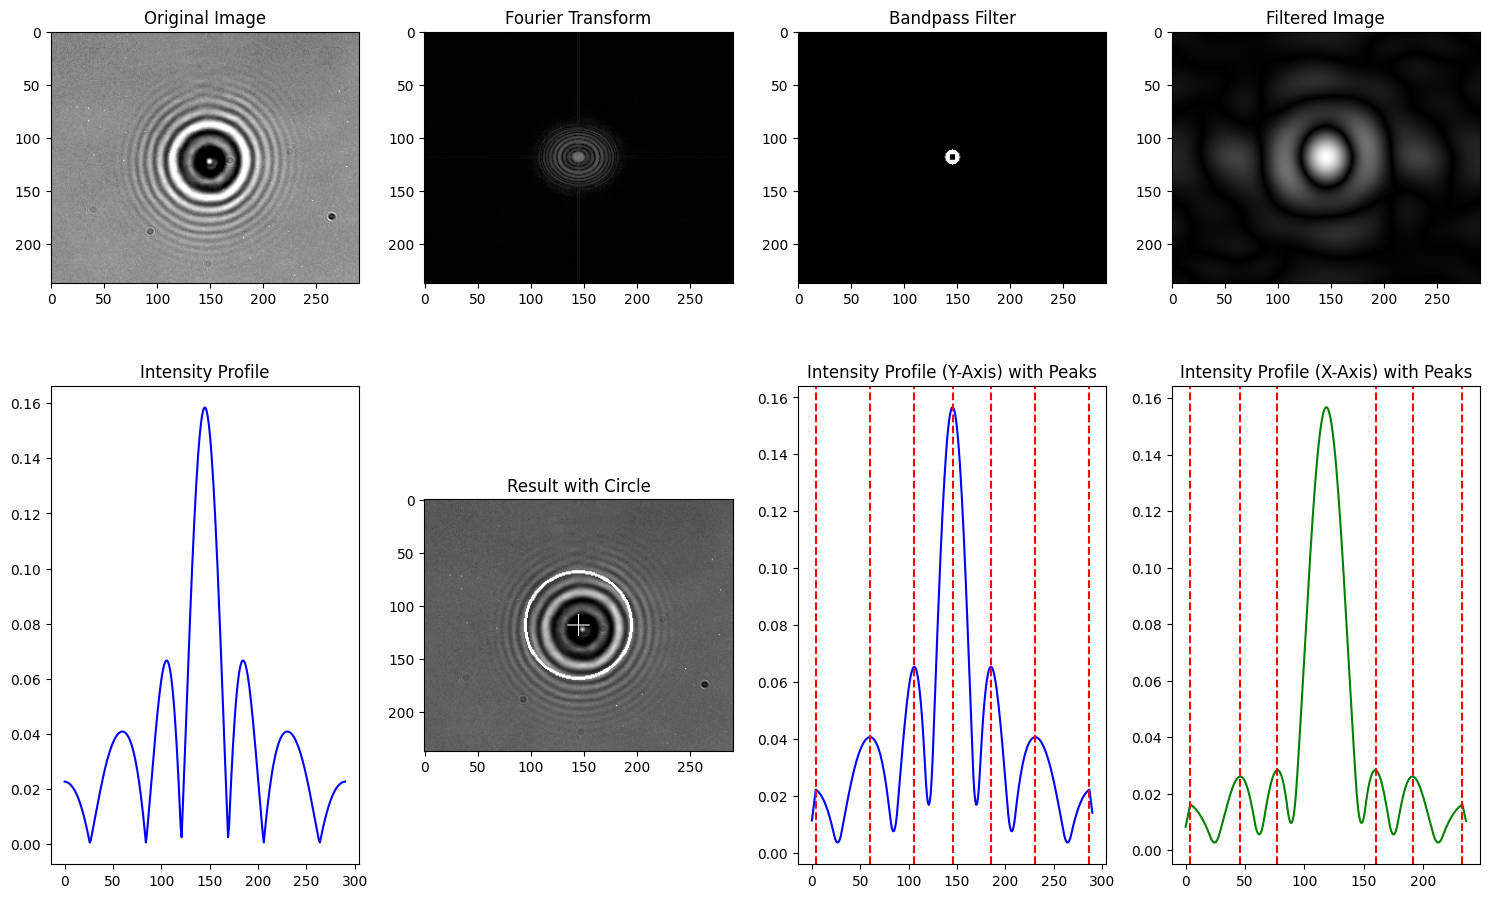

50.0
current: 145, left_peak: 106, right_peak: 185, refined center: 145
 [  4  60 106] || [185 231 287]
current: 118, left_peak: 77, right_peak: 160, refined center: 118
 [ 4 46 77] || [160 191 233]


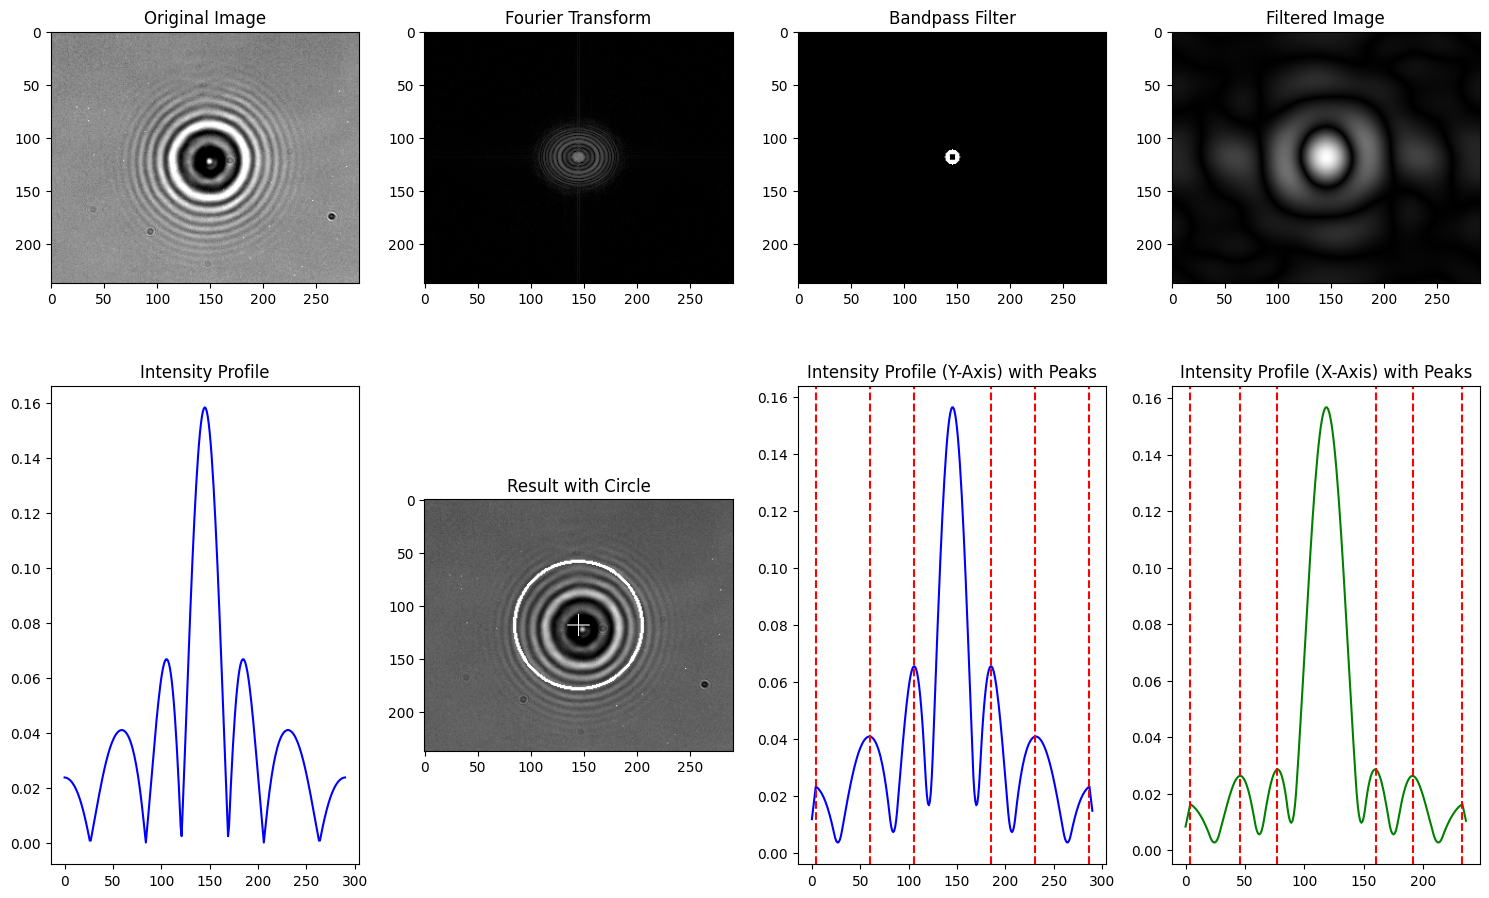

60.0
current: 145, left_peak: 104, right_peak: 187, refined center: 145
 [  4  59 104] || [187 232 287]
current: 118, left_peak: 76, right_peak: 161, refined center: 118
 [ 4 45 76] || [161 192 233]


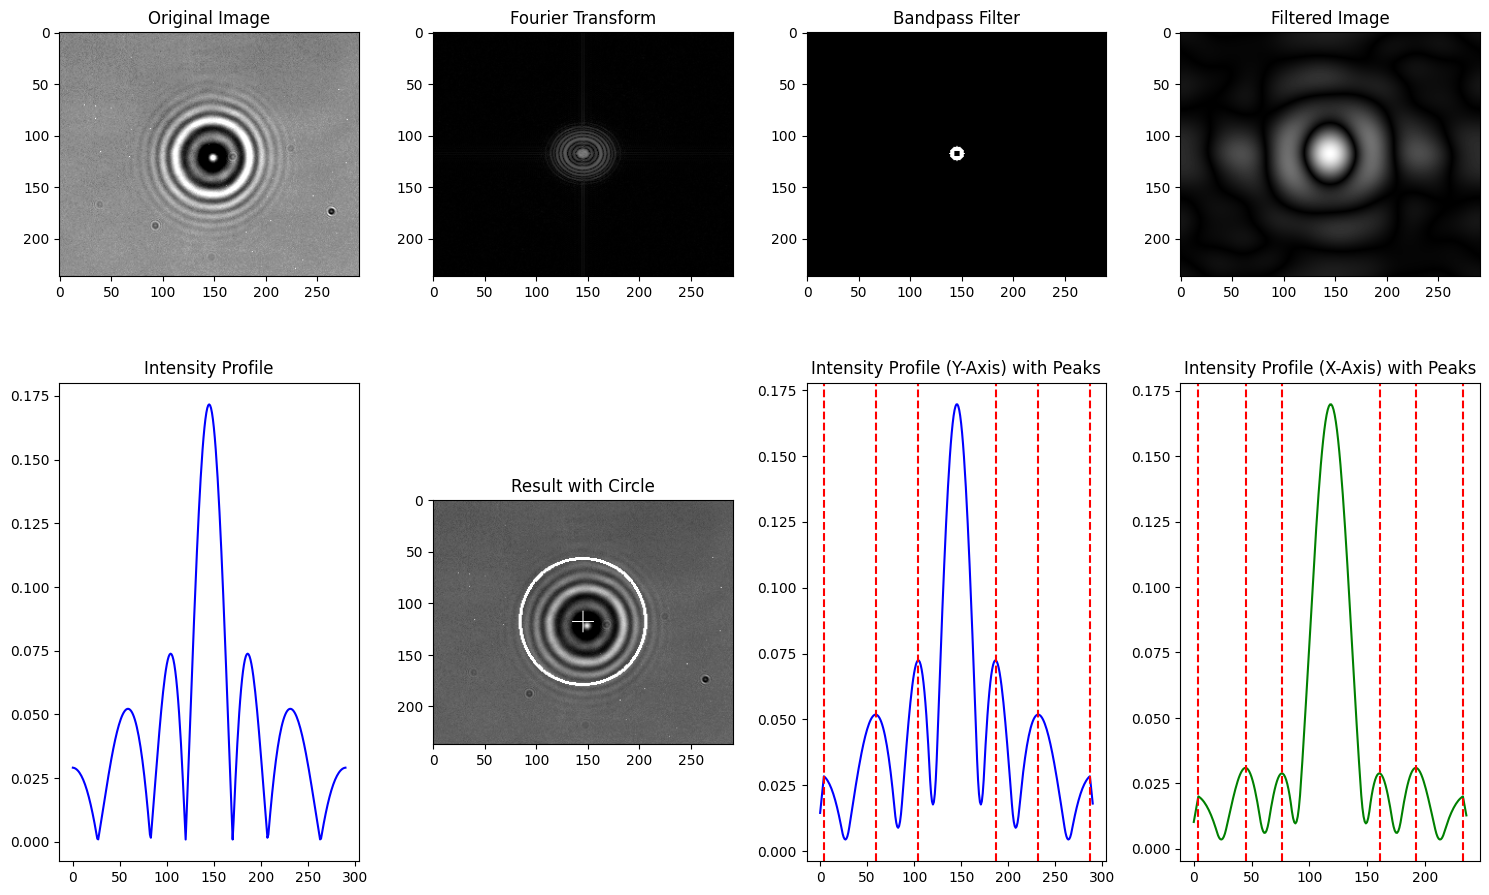

61.0
current: 145, left_peak: 103, right_peak: 188, refined center: 145
 [  4  58 103] || [188 233 287]
current: 118, left_peak: 76, right_peak: 161, refined center: 118
 [ 4 44 76] || [161 193 233]
60.8
low


NameError: name 'peaks_x' is not defined

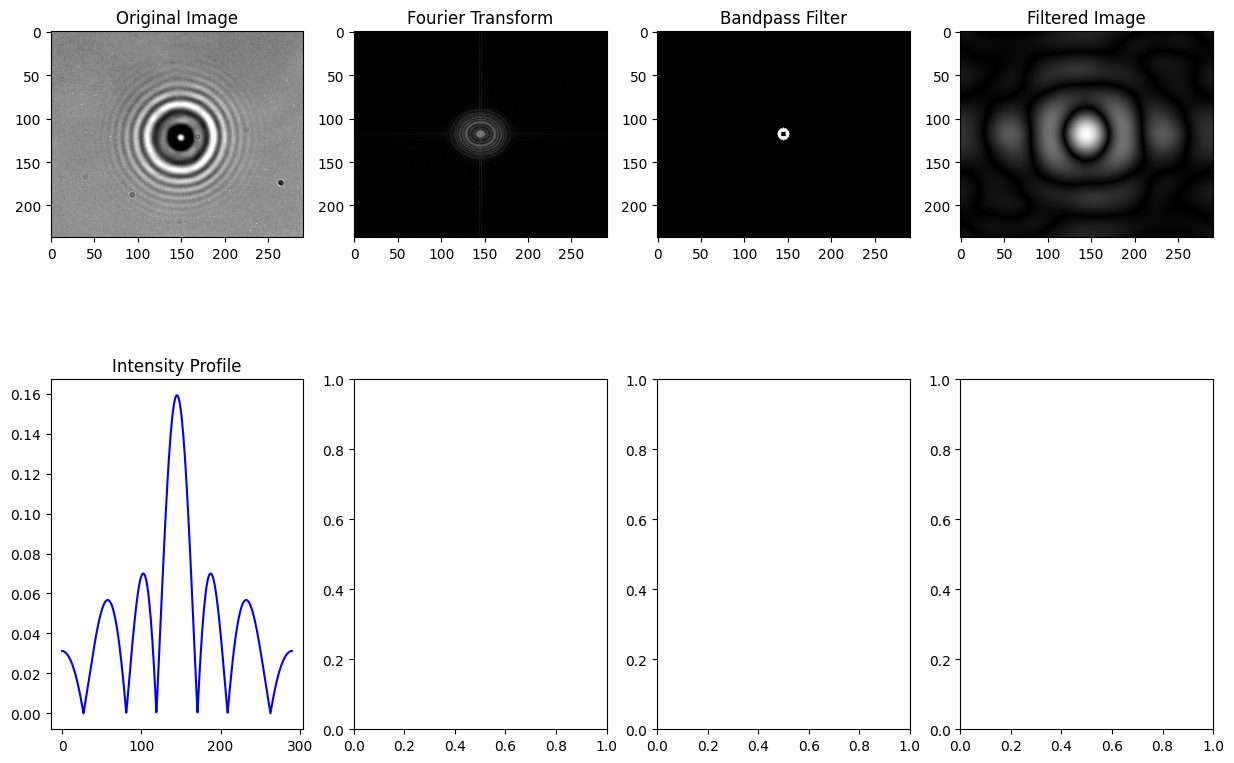

In [18]:
test='4'
params={
    'r_in':3,
    'r_out':7,
    'ring_index':1,
    'allowed_change':0.2,
    'input_path':'Tiffs',
    'input_tiff':f'Test_{test}.tif',
    'output_base_path':f'/Results/Test_{test}'
}
print(params)
ring_search(**params)